Install the STATCan to Python API: \
pip install stats-can

In [ ]:
import numpy as np
import pandas as pd
from stats_can import StatsCan
import os.path
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

sc = StatsCan()
sc.update_tables()

c:\Users\James has a PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\stats_can\api_class.py:24: FutureWarning: This class will be deprecated in upcoming v3 release. Please see the docs for details
  warn(
c:\Users\James has a PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\stats_can\sc.py:500: FutureWarning: This function will be deprecated in the v3 release. Please see the docs for details.
  warn(
c:\Users\James has a PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\stats_can\sc.py:451: FutureWarning: This function will be deprecated in the v3 release. Please see the docs for details.
  warn(
c:\Users\James has a PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\stats_can\sc.py:276: FutureWarning: This function will be deprecated in the v3 release. Please see the docs for details.
  warn(


[]

In [6]:
# Pull the dataset for agricultaral prices from StatsCan
price_data = sc.table_to_df("32-10-0077-01")

# Index the data so that every there is one row for every month, province and product. This creates NA values.
full_dates = pd.date_range(start='1992-01-01', end='2023-12-31', freq='MS')
provinces = np.unique(price_data['GEO'])
products = np.unique(price_data['Farm products'])
multi_index = pd.MultiIndex.from_product([full_dates, provinces, products], names=['REF_DATE', 'GEO', 'Farm products'])
price_data.set_index(['REF_DATE', 'GEO', 'Farm products'], inplace=True)
price_data = price_data.reindex(multi_index).reset_index()

# Rename Ontario wheat to Wheat
price_data.loc[price_data['Farm products'] == 'Ontario wheat excluding payments', 'Farm products'] = 'Wheat (except durum wheat) [1121111]'

# Get columns for year and month
price_data['YEAR'] = price_data['REF_DATE'].dt.year
price_data['MONTH'] = price_data['REF_DATE'].dt.month

# Remove values that start after 1992 or stop updating prior to 2023
products_to_remove = ['Barley for malt and other human consumption [11511412]',
    'Unprocessed milk from bovine [11612111]',
    'Fresh potatoes [114211]',
    'Fresh potatoes for processing [114211211]',
    'Fresh potatoes for seed [114211311]',
    'Fresh potatoes for table consumption [114211111]',
    'Barley for animal feed [115114111]',
    'Durum wheat [112111211]',
    'Canadian Wheat Board, barley excluding payments',
    'Canadian Wheat Board, barley including payments',
    'Canadian Wheat Board, durum excluding payments',
    'Canadian Wheat Board, durum including payments',
    'Canadian Wheat Board, selected barley excluding payments',
    'Canadian Wheat Board, selected barley including payments',
    'Canadian Wheat Board, wheat excluding payments',
    'Canadian Wheat Board, wheat including payments',
    'Non-board wheat (except durum wheat)',
    'Wheat (except durum wheat), milling',
    'Wheat (except durum wheat), other',
    'Canary seeds [11511555]',
    'Rye [1151152]',
    'Ontario wheat excluding payments',
    'Ontario wheat including payments']
rows_to_keep = price_data['Farm products'].apply(lambda x: x not in products_to_remove)
price_data = price_data[rows_to_keep]

# The following are being removed because the provinces do not have updated values for recent years for the corresponding products
rows_to_keep = ~((price_data['Farm products'] == 'Chickens for meat [11113131]') * (price_data['GEO'] == 'Newfoundland and Labrador'))
price_data = price_data[rows_to_keep]
rows_to_keep = ~((price_data['Farm products'] == 'Lentils [114312]') * (price_data['GEO'] == 'Manitoba'))
price_data = price_data[rows_to_keep]
rows_to_keep = ~((price_data['Farm products'] == 'Soybeans [1151211]') * (price_data['GEO'] == 'Saskatchewan'))
price_data = price_data[rows_to_keep]
rows_to_keep = ~((price_data['Farm products'] == 'Hogs [111121]') * (price_data['GEO'] == 'Newfoundland and Labrador'))
price_data = price_data[rows_to_keep]

# Get rid of the useless columns
columns_to_keep = ['GEO', 'REF_DATE', 'YEAR', 'MONTH', 'Farm products', 'VALUE']
price_data = price_data[columns_to_keep]

# Assign the products to categories we define
category_dict = {
    'Barley [1151141]' : 'plant',
    'Calves for feeding [11111122]' : 'cattle',
    'Calves for slaughter [111111211]' : 'cattle',
    'Cattle for feeding [11111112]' : 'cattle',
    'Cattle for slaughter [11111111]' : 'cattle',
    'Chickens for meat [11113131]' : 'poultry',
    'Corn for grain [1151111]' : 'plant',
    'Cows for slaughter [111111111]' : 'cattle',
    'Dry peas [114314]' : 'plant',
    'Eggs in shell [116111]' : 'poultry',
    'Flaxseed [115122111]' : 'plant',
    'Heifers for feeding [111111122]' : 'cattle',
    'Heifers for slaughter [111111114]' : 'cattle',
    'Hogs [111121]' : 'otheranimal',
    'Lambs [11114112]' : 'otheranimal',
    'Lentils [114312]' : 'plant',
    'Oats [115113111]' : 'plant',
    'Ontario wheat excluding payments' : 'plant',
    'Ontario wheat including payments' : 'plant',
    'Soybeans [1151211]' : 'plant',
    'Steers for feeding [111111121]' : 'cattle',
    'Steers for slaughter [111111113]' : 'cattle',
    'Turkeys for meat [111132211]' : 'poultry',
    'Wheat (except durum wheat) [1121111]' : 'plant',
    'Canola (including rapeseed) [113111]' : 'plant'
}
price_data['Category'] = price_data['Farm products'].apply(lambda x: category_dict.get(x, None))

# Assign the products in to for_slaughter, for_feeding, and none 
cattletype_dict = {x : 'for_slaughter' if 'for slaughter' in x else 'for_feeding' if 'for feeding' in x else 'None' for x in category_dict.keys()}
price_data['CattleType'] = price_data['Farm products'].apply(lambda x: cattletype_dict.get(x, None))

# Rename "XXX for feeding" to "XXX"
newProdNamesDict = {x : x if cattletype_dict[x] == 'None' else x[:x.find('for') - 1]  for x in cattletype_dict.keys()}
price_data['Farm products'] = price_data['Farm products'].apply(lambda x: newProdNamesDict.get(x, None))

# Rename the column VALUE to Product_Price
price_data= price_data.rename(columns={'VALUE': 'Product_Price'})

c:\Users\James has a PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\stats_can\sc.py:608: FutureWarning: This function will be deprecated in the v3 release. Please see the docs for details.
  warn(
c:\Users\James has a PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\stats_can\sc.py:326: FutureWarning: This function will be deprecated in the v3 release. Please see the docs for details.
  warn(


In [7]:
provinces = np.unique(price_data['GEO'])
products = np.unique(price_data['Farm products'])

# Calculate the mean price for each product
mean_products = {product: price_data['Product_Price'][price_data['Farm products'] == product].mean() for product in products}

# Calculate the ratio of the mean price for each product in each province to the overall mean price for that product
ratios = [
    [
        price_data['Product_Price'][(price_data['Farm products'] == product) & (price_data['GEO'] == province)].mean() / mean_products[product]
        for province in provinces
    ]
    for product in products
]

def na_fun(province, product, date):
    product_index = np.where(products == product)[0][0]
    prov_index = np.where(provinces == province)[0][0]

    return ratios[product_index][prov_index] * price_data['Product_Price'][(price_data['REF_DATE'] == date) * (price_data['Farm products'] == product)].mean()

price_data['Product_Price'] = price_data.apply(lambda row: na_fun(row['GEO'], row['Farm products'], row['REF_DATE']) if np.isnan(row['Product_Price']) else row['Product_Price'], axis=1)

price_data = price_data[price_data['Product_Price'].notna()]

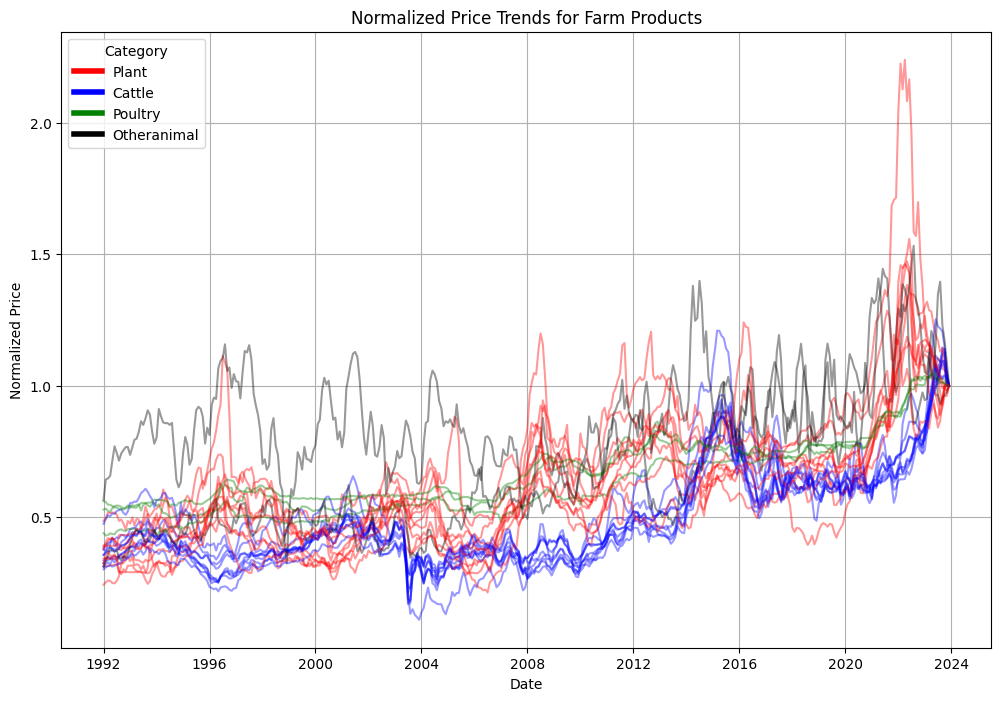

In [8]:
# Group data by relevant columns and calculate the mean Product Price
canada_wide_data = price_data.groupby(['REF_DATE', 'Farm products', 'Category', 'CattleType'])['Product_Price'].mean().reset_index()

# Get the most recent price for each Farm product, Category, and CattleType
last_prices = canada_wide_data.groupby(['Farm products', 'Category', 'CattleType'])['Product_Price'].last()

# Map the most recent price to each row in the canada_wide_data
canada_wide_data['Most Recent Price'] = [
    last_prices[(
        row['Farm products'],
        row['Category'],
        row['CattleType']
    )]
    for _, row in canada_wide_data.iterrows()
]

# Normalize the product price by dividing by the most recent price
canada_wide_data['Normalized_Price'] = canada_wide_data['Product_Price'] / canada_wide_data['Most Recent Price']

# Get unique combinations of Farm products, Category, and CattleType
categories = canada_wide_data[['Farm products', 'Category', 'CattleType']].drop_duplicates()

# Plotting normalized price trends
plt.figure(figsize=(12, 8))

# Define colors for each category
category_colors = {
    'plant': 'red',
    'cattle': 'blue',
    'poultry': 'green',
    'otheranimal': 'black'
}

# Loop through each unique category combination and plot the data
for i in range(categories.shape[0]):
    product = categories.iloc[i]['Farm products']
    category = categories.iloc[i]['Category']
    cattleType = categories.iloc[i]['CattleType']

    # Get color for the current category
    color = category_colors.get(category, 'black')

    # Filter data for the current combination
    product_data = canada_wide_data[
        (canada_wide_data['Farm products'] == product) & 
        (canada_wide_data['CattleType'] == cattleType)
    ]

    # Plot the normalized price trend
    plt.plot(product_data['REF_DATE'], product_data['Normalized_Price'], label=product, alpha=0.4, color=color)

# Create custom legend
legend_elements = [Line2D([0], [0], color=color, lw=4, label=category.capitalize()) for category, color in category_colors.items()]

# Set plot title and labels
plt.title('Normalized Price Trends for Farm Products')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.grid(True)
plt.legend(handles=legend_elements, title="Category")  # Add custom legend to the plot
#plt.xlim(pd.Timestamp("2016-01-01"), pd.Timestamp("2016-12-31"))
plt.show()

In [9]:
grouped = price_data.groupby(['Farm products', 'Category', 'CattleType', 'GEO'])
result = grouped.agg(
    first_date = ('REF_DATE', 'first'),
    last_date=('REF_DATE', lambda x: x[price_data.loc[x.index, 'Product_Price'].notna()].max()),
    missing_data = ('Product_Price', lambda x: x.isna().sum()),
    count_of_data = ('Product_Price', lambda x: (~x.isna()).sum())
).dropna(how='all')

result.to_csv('Products_to_predict.csv')

In [10]:
# Load data from the given tables
GDP = sc.table_to_df("36-10-0434-01")

# Filter the data for 'Crop and animal production [11A]' and 'Chained (2017) dollars'
GDP = GDP[(GDP['North American Industry Classification System (NAICS)'] == 'Crop and animal production [11A]') & (GDP['Prices'] == 'Chained (2017) dollars')]

# Load GDP data by province from the specified table
GDP_byprov = sc.table_to_df("36-10-0402-02")

# Filter the GDP_byprov data for 'Crop and animal production [11A]' and 'Chained (2017) dollars'
GDP_byprov = GDP_byprov[
    (GDP_byprov['North American Industry Classification System (NAICS)'] == 'Crop and animal production [11A]') & 
    (GDP_byprov['Value'] == 'Chained (2017) dollars')
]

# Extract yearly GDP data and add a YEAR column
gdp_yearly = GDP_byprov.loc[:, ['GEO', 'VALUE']]
gdp_yearly['YEAR'] = GDP_byprov['REF_DATE'].dt.year

# Create a copy of 2023 data for 2024
gdp_2024 = gdp_yearly[gdp_yearly['YEAR'] == 2023].copy()
gdp_2024['YEAR'] = 2024

# Concatenate the 2024 data with the yearly data
gdp_yearly = pd.concat([gdp_yearly, gdp_2024], ignore_index=True)

# Extract monthly GDP data and add YEAR and MONTH columns
gdp_monthly = GDP.loc[:, ['VALUE', 'REF_DATE']]
gdp_monthly['YEAR'] = GDP['REF_DATE'].dt.year
gdp_monthly['MONTH'] = GDP['REF_DATE'].dt.month
gdp_monthly = gdp_monthly.rename(columns={'VALUE': 'Canada_GDP'})

# Calculate the total yearly GDP by summing the values grouped by YEAR
gdp_yearly_totals = gdp_yearly.groupby('YEAR')['VALUE'].sum()

# Merge the monthly and yearly GDP data
merged_gdp = pd.merge(gdp_monthly, gdp_yearly, on='YEAR', how='left')

# Calculate the proportion of GDP by province
merged_gdp['Province_Proportion'] = merged_gdp['VALUE'] / gdp_yearly_totals[merged_gdp['YEAR']].values

# Calculate the monthly GDP by province
merged_gdp['Monthly_GDP_by_Province'] = merged_gdp['Canada_GDP'] * merged_gdp['Province_Proportion']

# Select columns to keep for the final dataset
columns_to_keep = ['GEO', 'YEAR', 'MONTH', 'Monthly_GDP_by_Province']
clean_gdp = merged_gdp[columns_to_keep]

# Rename GDP title
clean_gdp = clean_gdp.rename(columns={'Monthly_GDP_by_Province': 'GDP'})

c:\Users\James has a PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\stats_can\sc.py:608: FutureWarning: This function will be deprecated in the v3 release. Please see the docs for details.
  warn(
c:\Users\James has a PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\stats_can\sc.py:326: FutureWarning: This function will be deprecated in the v3 release. Please see the docs for details.
  warn(
c:\Users\James has a PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\stats_can\sc.py:608: FutureWarning: This function will be deprecated in the v3 release. Please see the docs for details.
  warn(
c:\Users\James has a PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\stats_can\sc.py:326: FutureWarning: This function will be deprecated in the v3 release. Please see the docs for details.
  warn(


In [11]:
yearly_cleaned = clean_gdp.groupby(['GEO', 'YEAR'])['GDP'].sum().reset_index()

# Load full GDP data from the specified table
GDP_full = sc.table_to_df("36-10-0222-01")

valid_provinces = ['Ontario', 'Quebec', 'British Columbia', 'Nova Scotia', 'New Brunswick', 'Manitoba', 'Prince Edward Island', 'Saskatchewan', 'Alberta', 'Newfoundland and Labrador', 'Northwest Territories', 'Yukon', 'Nunavut']

GDP_full = GDP_full[GDP_full['GEO'].isin(valid_provinces)]

GDP_full['YEAR'] = GDP_full['REF_DATE'].dt.year

# Filter the GDP_full data for 'Final consumption expenditure' and 'Chained (2017) dollars'
GDP_full = GDP_full[
    (GDP_full['Estimates'] == 'Final consumption expenditure') & 
    (GDP_full['Prices'] == 'Chained (2017) dollars')
]

# Merge the provincial GDP data with the full GDP data on 'GEO' and 'REF_DATE'
merged_df = pd.merge(
    yearly_cleaned, GDP_full, 
    on=['GEO', 'YEAR'], 
    suffixes=('_provinces', '_full'), 
    how='right'
)

merged_df['ratios'] = merged_df['VALUE'] / merged_df['GDP']

# Calculate the mean ratio for each 'GEO'
ratios = merged_df[(merged_df['YEAR'] == 1997)].loc[:,('GEO','ratios')].set_index('GEO')

# Function to replace NaN 'VALUE_provinces' with the estimated value using ratios
def replaceWithRatio(row):
    if pd.isna(row['GDP']):
        return row['VALUE'] / ratios.loc[row['GEO']]
    else:
        return row['GDP']

# Apply the function row-wise to create a new 'VALUE' column
merged_df['VALUE'] = merged_df.apply(replaceWithRatio, axis=1)

# Select the relevant columns for the final output
GDP_old = merged_df.loc[:, ['YEAR', 'GEO', 'VALUE']]

C:\Users\James has a PC\AppData\Local\Temp\ipykernel_14556\891774095.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  yearly_cleaned = clean_gdp.groupby(['GEO', 'YEAR'])['GDP'].sum().reset_index()
c:\Users\James has a PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\stats_can\sc.py:608: FutureWarning: This function will be deprecated in the v3 release. Please see the docs for details.
  warn(
c:\Users\James has a PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\stats_can\sc.py:326: FutureWarning: This function will be deprecated in the v3 release. Please see the docs for details.
  warn(


In [12]:
GDP_old['VALUE'] = GDP_old['VALUE'].replace(np.nan,0)
GDP_old['REF_DATE'] = pd.to_datetime(GDP_old['YEAR'], format='%Y')
GDP_old.set_index('REF_DATE', inplace=True)

# Function to resample, interpolate and scale the data for each group
def interpolate_group(group):
    # Resample to monthly frequency
    monthly_group = group.resample('MS').asfreq()
    
    # Linear interpolation
    monthly_group['VALUE'] = monthly_group['VALUE'].interpolate(method='linear')
    
    # Forward fill the annual values to monthly frequency
    annual_values = group.resample('MS').ffill()
    
    # Calculate the scaling factor for each month
    monthly_sums = monthly_group.resample('Y').sum()
    scaling_factors = (annual_values / monthly_sums.reindex(annual_values.index, method='ffill')).fillna(1)
    
    # Apply the scaling factor to ensure the sum of the months equals the annual data
    monthly_group['VALUE'] *= scaling_factors['VALUE']
    
    return monthly_group

# Apply the function to each group
monthly_dfs = GDP_old.groupby('GEO').apply(interpolate_group).reset_index()

monthly_dfs['YEAR'] = monthly_dfs['REF_DATE'].dt.year
monthly_dfs['MONTH'] = monthly_dfs['REF_DATE'].dt.month

In [13]:
date_range1 = pd.date_range('1990-01-01', '2024-10-01', freq='MS')
clean_gdp['REF_DATE'] = pd.to_datetime([str(x) + '-' + str(y) for x,y in zip(clean_gdp['YEAR'],clean_gdp['MONTH'])])
provinces = np.unique(clean_gdp['GEO'])
multi_index = pd.MultiIndex.from_product([date_range1, provinces], names=['REF_DATE', 'GEO'])
clean_gdp.set_index(['REF_DATE', 'GEO'], inplace=True)
clean_gdp = clean_gdp.reindex(multi_index).reset_index()

clean_gdp['YEAR'] = clean_gdp['REF_DATE'].dt.year
clean_gdp['MONTH'] = clean_gdp['REF_DATE'].dt.month

combined_gdp = pd.merge(clean_gdp, monthly_dfs, on = ['REF_DATE', 'GEO'], how='left')
combined_gdp = combined_gdp.drop(['YEAR_x', 'MONTH_x', 'YEAR_y', 'MONTH_y'], axis=1)
combined_gdp['GDP'] = combined_gdp['GDP'].fillna(combined_gdp['VALUE'])

In [14]:
gdp_grouped = combined_gdp.set_index(['REF_DATE', 'GEO'])
gdp_grouped = gdp_grouped.drop(['VALUE'], axis=1)

log_gdp_change = []

for index, row in gdp_grouped.iterrows():
    date = index[0]
    daten1 = index[0] + pd.DateOffset(years=-1)
    prov = index[1]
    
    if not ((daten1, prov) in gdp_grouped.index):
        log_gdp_change.append(np.nan)
        continue

    gdp_change = np.log(gdp_grouped.loc[date, prov] / gdp_grouped.loc[daten1, prov])

    log_gdp_change.append(gdp_change.values[0])

test = pd.DataFrame(log_gdp_change)
test.columns = gdp_grouped.columns

clean_gdp['GDP'] = test['GDP']

clean_gdp = clean_gdp.drop('REF_DATE', axis=1)

# Save the cleaned data to a CSV file
clean_gdp.to_csv('GDP.csv', index=False)

In [15]:
oil = sc.table_to_df("18-10-0001-01")

def split_comma(value):
    prov = value.split(",")[-1]
    return prov[1:]

# Apply the function to every cell in the 'Values' column
oil['Prov_Ter'] = oil['GEO'].apply(split_comma)
oil.loc[oil['Prov_Ter'] == 'Ontario/Quebec','Prov_Ter'] = 'Quebec'

oil['YEAR'] = oil['REF_DATE'].dt.year
oil['MONTH'] = oil['REF_DATE'].dt.month

columns_to_keep = ['Prov_Ter', 'YEAR', 'MONTH', 'Type of fuel', 'VALUE']

oil_clean = oil[columns_to_keep]

oil_clean = oil_clean.groupby(['Prov_Ter', 'YEAR', 'MONTH', 'Type of fuel']).mean()

oil_clean = oil_clean.reset_index()

oil_clean = pd.pivot_table(
    oil_clean,
    values='VALUE', 
    index=['Prov_Ter', 'YEAR', 'MONTH'],
    columns=['Type of fuel'],
    aggfunc='mean'
    ).reset_index()

oil_clean.rename(columns={'Regular unleaded gasoline at self service filling stations': 'Gas_Regular',
                          'Diesel fuel at self service filling stations': 'Diesel'}, inplace=True)

oil_clean['Diesel'] = oil_clean['Diesel'].fillna(oil_clean['Diesel fuel at full service filling stations'])

oil_clean = oil_clean.loc[:, ['Prov_Ter', 'YEAR', 'MONTH', 'Diesel', 'Gas_Regular']]

oil_clean['REF_DATE'] = pd.to_datetime([str(x) + '-' + str(y) for x,y in zip(oil_clean['YEAR'],oil_clean['MONTH'])])
oil_grouped = oil_clean.set_index(['REF_DATE', 'Prov_Ter'])
oil_grouped = oil_grouped.drop(['YEAR', 'MONTH'], axis=1)

log_gdp_change = []

for index, row in oil_grouped.iterrows():
    date = index[0]
    daten1 = index[0] + pd.DateOffset(years=-1)
    prov = index[1]
    
    if not ((daten1, prov) in oil_grouped.index):
        log_gdp_change.append([np.nan, np.nan])
        continue

    gdp_change = np.log(oil_grouped.loc[date, prov] /oil_grouped.loc[daten1, prov])

    log_gdp_change.append(gdp_change)

test = pd.DataFrame(log_gdp_change)
test.columns = oil_grouped.columns

oil_clean['Diesel'] = test['Diesel']
oil_clean['Gas_Regular'] = test['Gas_Regular']

oil_clean = oil_clean.drop('REF_DATE', axis=1)

oil_clean.to_csv('oil.csv')

c:\Users\James has a PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\stats_can\sc.py:608: FutureWarning: This function will be deprecated in the v3 release. Please see the docs for details.
  warn(
c:\Users\James has a PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\stats_can\sc.py:326: FutureWarning: This function will be deprecated in the v3 release. Please see the docs for details.
  warn(


In [16]:
if os.path.isfile('weather_data.csv'):
    weather_data = pd.read_csv('weather_data.csv')
else:
    weather_data = getAllMonthlyData()
    weather_data.to_csv('weather_data.csv')

In [17]:
df = pd.merge(left=price_data, right=clean_gdp, left_on= ['GEO', 'YEAR', 'MONTH'], right_on = ['GEO', 'YEAR', 'MONTH'], how='left')
df = pd.merge(left=df, right=oil_clean, left_on= ['GEO', 'YEAR', 'MONTH'], right_on = ['Prov_Ter', 'YEAR', 'MONTH'], how='left')
df = pd.merge(left=df, right=weather_data, left_on= ['GEO', 'YEAR', 'MONTH'], right_on = ['Prov_or_Ter', 'year', 'month'], how='left')

df['log_price'] = np.log(df['Product_Price'])

In [18]:
log_grouped = df.groupby(['REF_DATE', 'GEO', 'Category', 'Farm products', 'CattleType'])['log_price'].first()

date_range1 = pd.date_range(pd.Timestamp('1993-01-01'), pd.Timestamp('2023-12-01'), freq = 'MS')
date_range2 = pd.date_range(pd.Timestamp('1992-01-01'), pd.Timestamp('2022-12-01'), freq = 'MS')

yoy_change = [log_grouped.loc[d1] - log_grouped.loc[d2] for d1, d2 in zip(date_range1, date_range2)]

yoy_full = []

for index, row in df.iterrows():
    date = row['REF_DATE']
    
    if date not in date_range1.to_list():
        yoy_full.append(np.nan)
        continue
    
    yoy_index = date_range1.to_list().index(date)

    prov = row['GEO']
    prod_type = row['Category']
    prod = row['Farm products']
    cattle = row['CattleType']

    yoy = yoy_change[yoy_index].loc[prov, prod_type, prod, cattle]

    yoy_full.append(yoy)
    
df['YoY_change'] = yoy_full

In [19]:
df = df[df['YEAR'] != 1992]
df = df[df['YEAR'] != 1993]
df = df[df['YEAR'] != 2024]
df = df[df['YEAR'] != 2023]

df = df.drop(['year', 'month', 'YEAR', 'MONTH', 'Prov_Ter', 'Prov_or_Ter'], axis = 1)

df.to_csv('full_data.csv')

In [ ]:
MONTHS_BACK = 4

indexed_df = df.set_index(['REF_DATE', 'GEO', 'Category', 'Farm products', 'CattleType'])
indexed_df = indexed_df.drop(['log_price', 'Product_Price'], axis=1)

datas = []
for i in range(-MONTHS_BACK + 1, 1):
    tmn = []
    cols = indexed_df.columns

    for index, row in indexed_df.iterrows():
        date = index[0] + pd.DateOffset(months=i)
        
        if not (df['REF_DATE'] == date).any():
            continue

        prov = index[1]
        prod_type = index[2]
        prod = index[3]
        cattle = index[4]

        values = indexed_df.loc[date, prov, prod_type, prod, cattle]
        tmn.append(values)

    test = pd.DataFrame(tmn)
    test.index = test.index.set_names(['REF_DATE', 'GEO', 'Category', 'Farm products', 'CattleType'])
    test = test.reset_index()
    test['REF_DATE'] += pd.DateOffset(months=-i)
    test = test.set_index(['REF_DATE', 'GEO', 'Category', 'Farm products', 'CattleType'])
    test.columns += '_' + str(i)
    datas.append(test)

final_data = pd.concat(datas, axis = 1)

In [ ]:
tmn = []
cols = indexed_df.columns

for index, row in indexed_df.iterrows():
    date = index[0] + pd.DateOffset(months=1)
    
    if not (df['REF_DATE'] == date).any():
        tmn.append(np.nan)
        continue

    prov = index[1]
    prod_type = index[2]
    prod = index[3]
    cattle = index[4]

    values = indexed_df.loc[date, prov, prod_type, prod, cattle]
    tmn.append(values['YoY_change'])

test = pd.DataFrame(tmn)
test.index = indexed_df.index
test.columns = ['YoY_change_1']

final_data = pd.concat([final_data, test], axis = 1)

In [ ]:
final_data = final_data.dropna()
final_data.to_csv(f'data_{MONTHS_BACK}.csv')